# The Spectacular Sailors - Checkpoint 4 Machine Learning

# In this Checkpoint


*   Can we predict whether an officer is in a crew, a community, or is unaffiliated?
*   Can we whether any particular group of officers is a crew or not based on aggregated data about their member officers?


# Getting Started
Libraries and tools for this analysis:


*   Data Structures: Numpy and Pandas
*   Machine Learning: SKLearn
*   Data Extraction: DataGrip (PostgreSQL)
*   Data Source: CPDB
*   Analyzed Data: The Spectacular Sailors/Checkpoint 4/src


In [305]:
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn_pandas import DataFrameMapper
import matplotlib.pyplot as plt

In [306]:
# read the officer and cohort data into pandas dataframe
url = 'https://raw.githubusercontent.com/Northwestern-Data-Sci-Seminar/Invisible-Institute-Chicago-Reporter-Collaboration-Public/master/The%20Spectacular%20Sailors/Checkpoint_4/src/officers_crews_ml_2.csv'
df = pd.read_csv(url, header = 0)
df = df._get_numeric_data()
original_headers = list(df.columns.values)
df

,officer_id,avg_coaccusals,avg_years_on_force_at_incident,avg_age_at_incident,gender,avg_complaint_percentile,avg_disciplined_count,cohort_id,avg_allegation_severity,max_allegation_severity
0,1,2.166667,5.500000,39.500000,1,61.2357,0.000000,3,4.198333,9.60
1,2,4.250000,4.750000,29.750000,0,72.0378,0.000000,2,11.867500,16.59
2,4,1.714286,27.428571,54.428571,1,49.0044,0.000000,2,9.515714,16.59
3,5,11.000000,37.500000,61.500000,1,74.7611,0.250000,2,7.120000,8.22
4,6,3.000000,8.500000,34.500000,1,45.5641,0.000000,3,6.781667,13.42
...,...,...,...,...,...,...,...,...,...,...
22469,33052,1.000000,10.000000,32.000000,0,15.9604,0.000000,3,6.300000,6.30
22470,33055,2.500000,1.666667,29.666667,0,40.9117,0.000000,3,8.330000,16.59
22471,33056,2.800000,13.400000,44.400000,0,45.1645,0.100000,2,11.319000,42.38
22472,33057,1.000000,7.000000,34.000000,0,34.8095,0.857143,3,6.574286,8.22


#  Predicting Officer Membership

**Question to answer: Given various attributes of an officer, what group do the belong to? Crew, Community, or Unaffiliated?**

**Motivation:** If we use crew membership as a proxy for elevated risk of misconduct, then predicting whether a police officer is in a crew may help inform intervention; however, what about an officer predicts whether they are in a crew?

The Invisible Institute classified police officers into different groups or cohorts based on a topic modeling analysis, as a result, we have a baseline set of target data for every officer in the dataset.

Based on the data_officercrew table, we selected and aggregated data about officers such as the average number of coaccusals, complaint percentile, and allegation severity to produce a table of approximately 20,000 officers. Given the classification of each officer into a group (1 for crew, 2 for community, and 3 for unaffiliated), we present the potential to identify what features of an officer best predict their membership.


In [307]:
# change the datatype in the dataframe
df['cohort_id'] = df['cohort_id'].astype('category',copy=False)
df['gender'] = df['gender'].astype('category',copy=False)
df['officer_id'] = df['officer_id'].astype('category',copy=False)
df.dtypes

officer_id                        category
avg_coaccusals                     float64
avg_years_on_force_at_incident     float64
avg_age_at_incident                float64
gender                            category
avg_complaint_percentile           float64
avg_disciplined_count              float64
cohort_id                         category
avg_allegation_severity            float64
max_allegation_severity            float64
dtype: object

In [308]:
# all minmaxscaler on avg_allegation_severity to scale the data
mapper_features  = DataFrameMapper([
                          (['avg_coaccusals'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_years_on_force_at_incident'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_age_at_incident'], sklearn.preprocessing.MinMaxScaler()), 
                          ('gender', sklearn.preprocessing.LabelBinarizer()),
                          (['avg_complaint_percentile'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_disciplined_count'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_allegation_severity'], sklearn.preprocessing.MinMaxScaler())
                          
])

# Data Processing
Prior to analyzing the data, we dropped several hundred records where the following calculated fields were null:


*   average years on force at incident
*   average complaint percentile
*   average allegation severity
*   maximum allegation severity

After dropping missing data, we mapped feature and target data with SKLearn MinMax Scaler and fit_transform. The results of the mapping process produced a features array and target array. Importantly, the scaled values allow us to scale each of the values to between 0 and 1 which means we can evaluate the value of their coeffients. In other words, we can determine which of the values impact the prediction.


In [309]:
# use the mapper to scale the data
features = np.round(mapper_features.fit_transform(df.copy()), 3)
features

array([[0.006, 0.436, 0.538, ..., 0.612, 0.   , 0.085],
       [0.017, 0.427, 0.432, ..., 0.72 , 0.   , 0.269],
       [0.004, 0.691, 0.7  , ..., 0.49 , 0.   , 0.213],
       ...,
       [0.009, 0.528, 0.591, ..., 0.452, 0.1  , 0.256],
       [0.   , 0.453, 0.478, ..., 0.348, 0.857, 0.142],
       [0.005, 0.523, 0.63 , ..., 0.   , 0.   , 0.003]])

In [310]:
# train test validation split
X_train, X_test, y_train, y_test = train_test_split(features, df['cohort_id'], test_size=0.3, shuffle=True)

In [311]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

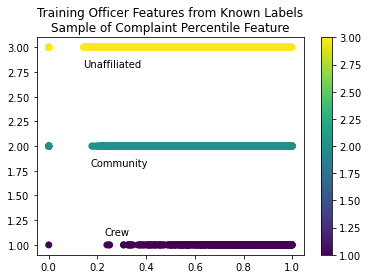

In [312]:
# Display a sample of how the features are trained with known classifications
plt.figure()
plt.title('Training Officer Features from Known Labels\nSample of Complaint Percentile Feature')
plt.scatter(X_train[:,4], y_train, c=y_train)
plt.text(.14, 2.8, "Unaffiliated")
plt.text(.17, 1.8, "Community")
plt.text(.23, 1.1, "Crew")
plt.colorbar()
plt.show()

In [313]:
# train the linear regression model using train data
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [314]:
# make predictions of cohorts
prediction = linreg.predict(X_val)
y_valnp = y_val.to_numpy()
predictionnp = np.around(prediction)
predictionnp

array([2., 3., 2., ..., 3., 2., 2.])

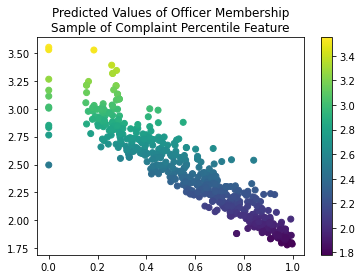

In [315]:
# Display a sample of the predicted values of each officer 
idx = np.random.choice(prediction.shape[0], size=500)
feats_example = X_val[:,4]

plt.figure()
plt.title('Predicted Values of Officer Membership\nSample of Complaint Percentile Feature')
# plt.scatter(y[idx], prediction[idx])
plt.scatter(feats_example[idx], prediction[idx], c=prediction[idx])
plt.colorbar()
# plt.text(.14, 2.8, "Unaffiliated")
# plt.text(.17, 1.8, "Community")
# plt.text(.23, 1.1, "Crew")
plt.show()

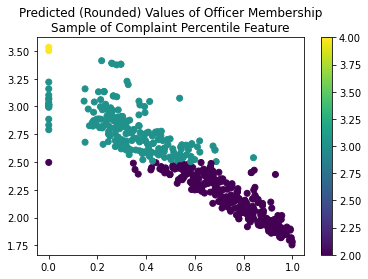

In [316]:
idx = np.random.choice(prediction.shape[0], size=500)
feats_example = X_val[:,4]

plt.figure()
plt.title('Predicted (Rounded) Values of Officer Membership\nSample of Complaint Percentile Feature')
# plt.scatter(y[idx], prediction[idx])
plt.scatter(feats_example[idx], prediction[idx], c=predictionnp[idx])
plt.colorbar()
# plt.text(.14, 2.8, "Unaffiliated")
# plt.text(.17, 1.8, "Community")
# plt.text(.23, 1.1, "Crew")
plt.show()

In [317]:
#show accuracy of model 1
metrics.accuracy_score(y_val, predictionnp)

0.7279738949866509

In [318]:
# coefficient of the linear model
linreg.coef_

array([-0.42844211,  0.24304242,  0.5470617 , -0.07993756, -1.21990411,
        0.42659133, -0.7339202 ])

In [319]:
# train a logistic regression on the data to check difference
logreg = linear_model.LogisticRegression(multi_class='ovr')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [320]:
# we got higher accuracy on logistic regression but generally they are the same
predictionlog = logreg.predict(X_val)
metrics.accuracy_score(y_valnp, predictionlog)

0.7356867398398101

# Data Results - Officer Membership

Based on the scaled values of each feature, we want to train and test predictions whether each row (officer) is in cohort 1, 2, or 3. The array of coefficients indicates which of the features most strongly impacts the prediction. Since we have linear regressions, the value of the coefficient indicates the feature that impacts prediction the most. In this case, the largest negative value is strongest and the largest positive value is weakest. 

As show below, the colunm with the strongest coeffiecient is complaint percentile. After considering the meaning, this makes sense - officers that rank highest in complaint percentile are more than likely part of a crew and associated with misocnduct. 

On the other hand, the number of years on force and age at incident appeared to have less effect on the prediction. This runs counter to an initial assumption that maturity might have an impact on misconduct.

**The current model has an accuracy of about 70%.**

In [ ]:
# read the officer and cohort data into pandas dataframe
url1 = 'https://raw.githubusercontent.com/Northwestern-Data-Sci-Seminar/Invisible-Institute-Chicago-Reporter-Collaboration-Public/master/The%20Spectacular%20Sailors/Checkpoint_4/src/officers_crews_ml_3.csv'
df1 = pd.read_csv(url1, header = 0)
df1 = df1._get_numeric_data()
original_headers = list(df1.columns.values)
df1

,cohort_id,member_count,years_on_force,percent_black,percent_white,percent_male,percent_female,internal_complaints_per_person,detected_crew
0,824,7,19.428571,14.285714,28.571429,71.428571,28.571429,4.285714,1
1,508,11,25.727273,0.000000,63.636364,90.909091,9.090909,3.545455,1
2,1130,5,22.400000,60.000000,20.000000,100.000000,0.000000,5.800000,1
3,294,4,22.000000,0.000000,0.000000,100.000000,0.000000,5.000000,1
4,403,13,26.153846,38.461538,53.846154,100.000000,0.000000,3.230769,1
...,...,...,...,...,...,...,...,...,...
2329,115,9,22.000000,0.000000,77.777778,44.444444,33.333333,4.111111,1
2330,883,13,9.500000,7.692308,30.769231,84.615385,7.692308,3.076923,1
2331,558,12,24.181818,83.333333,0.000000,75.000000,16.666667,4.083333,1
2332,830,7,30.000000,0.000000,85.714286,100.000000,0.000000,3.285714,1


In [ ]:
# change the datatype in the dataframe
df1['detected_crew'] = df1['detected_crew'].astype('category',copy=False)
df1.dtypes

cohort_id                            int64
member_count                         int64
years_on_force                     float64
percent_black                      float64
percent_white                      float64
percent_male                       float64
percent_female                     float64
internal_complaints_per_person     float64
detected_crew                     category
dtype: object

In [ ]:
# all minmaxscaler on avg_allegation_severity to scale the data
mapper_features1  = DataFrameMapper([
                          (['member_count'], sklearn.preprocessing.MinMaxScaler()),
                          (['years_on_force'], sklearn.preprocessing.MinMaxScaler()),
                          (['percent_black'], sklearn.preprocessing.MinMaxScaler()), 
                          (['percent_white'], sklearn.preprocessing.MinMaxScaler()),
                          (['percent_male'], sklearn.preprocessing.MinMaxScaler()),
                          (['internal_complaints_per_person'], sklearn.preprocessing.MinMaxScaler())
                          
])

In [ ]:
# use the mapper to scale the data
features1 = np.round(mapper_features1.fit_transform(df1.copy()), 3)
features1

array([[0.273, 0.466, 0.143, 0.286, 0.714, 0.245],
       [0.455, 0.617, 0.   , 0.636, 0.909, 0.203],
       [0.182, 0.538, 0.6  , 0.2  , 1.   , 0.331],
       ...,
       [0.5  , 0.58 , 0.833, 0.   , 0.75 , 0.233],
       [0.273, 0.72 , 0.   , 0.857, 1.   , 0.188],
       [0.273, 0.614, 0.   , 0.143, 1.   , 0.22 ]])

In [ ]:
# train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, df1['detected_crew'], test_size=0.3, shuffle=True)

In [ ]:
# train the linear regression model1 using train data
linreg1 = linear_model.LinearRegression()
linreg1.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# make predictions of cohorts
prediction1 = linreg1.predict(X_test1)
#y_valnp = y_val.to_numpy()
predictionnp1 = np.around(prediction1)
predictionnp1

array([-0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  1., -0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  1.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,
        0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,
       -0., -0.,  1., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,  1., -0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,  0., -0.,
       -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
       -0., -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0

In [ ]:
#show accuracy of model 1
metrics.accuracy_score(y_test1, predictionnp1)

0.9258202567760342

In [ ]:
# coefficient of the linear model
linreg1.coef_

array([ 0.01854292,  0.03480821,  0.00428483, -0.00797836, -0.00409844,
        1.45437381])

In [ ]:
# train a logistic regression on the data to check difference
logreg1 = linear_model.LogisticRegression(multi_class='auto')
logreg1.fit(X_train1, y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictionlog1 = logreg1.predict(X_test1)
metrics.accuracy_score(y_test1, predictionlog1)

0.9258202567760342

# Data Results - Group Crew Detection

Earlier, we attempted to predict whether individual officers belonged to a crew, community, or are unaffiliated. In this second model, we attempt to predict whether any grouping of officers is a crew or not. 

Similar to the earlier model, we want to know which feature of a group impacts the prediction of crew and whether such a model is accurate. This time, based on the data_crew table, we selected features that average information about the officers in their ranks such as member count, race, and complaints per person. 

According to our current model, the internal complaints per person and member count are most heavily weighted when predicting whether a group is classified as a crew or not.

**The current group detection model has an accuracy of about 90%.**


# Conclusion

It is possible to predict and model officer misconduct. 

At an indvidual level, officers with high complaint percentiles are most heavily weighted when predicting their cohort. 

At a group level, cohorts of officers with many members or with large numbers of complaints indicates there is a crew. 

If these metrics are tracked, it may be possible to detect whether individual officers are at higher risk of continued misconduct.